**Single Cell Resolution Analysis of Ca Imaging Data for Hydra** 
=============================================================
*(Use with data from tdTomato_GCamP Animals)*

Requires:
-------------------------
- Green and Red Channel Videos From 2-Colour Confocal (GCaMP Channel and tdTomato)
- Tracking Position Information From ICY Spot Tracking Protocol (Exported as CSV)
- Conda Environment: Caiman_NOAH3

INPUT PATHS
-----------------
Enter paths to the appropriate files                    
**Videos must be .avi (convert in imageJ if not)**     
**Can also use a Tif sequence folder - change the read data function to Read_Data_TIFseq for this**    
**If using windows**: Paths must start with an 'r' character: e.g. vid_path = **r**"C:\Users\rylab\ path to your file \clip.avi"

In [2]:
#input path to your .csv from ICY
csv_path = r"C:\Users\rylab\Desktop\AliA\Best 10X\Best 10X_ICY.csv"

#input path to .avi of GCaMP Video
vid_path = r"C:\Users\rylab\Desktop\AliA\Best 10X\Substack (1-3000)_G7.avi"

#input path to .avi of tdTomato Video
red_vid_path = r"C:\Users\rylab\Desktop\AliA\Best 10X\Substack (1-3000)_tdT.avi"

SET UP DATA  
-----------------------
Run the following cells to set up the 
data to be analysed        
**Set the FFmpeg path before running this cell**

In [1]:
#importing packages
import os
import numpy as np
import scipy as sp
import skimage.io as iio
import skvideo
from io import BytesIO
from PIL import Image

#set this path to the FFmpegTool\bin location on your machine (download FFmpeg if not already installed)
#make sure to restart the kernel after setting the path
skvideo.setFFmpegPath(r"C:\FFmpegTool\bin")

import skvideo.io as io
import pandas as pd
import matplotlib.pyplot as plt
from caiman.source_extraction.cnmf import deconvolution as deconv
from scipy.spatial.distance import cdist, pdist, euclidean
from sklearn.preprocessing import normalize
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import cv2

from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
import seaborn as sns
from matplotlib.colors import rgb2hex, colorConverter
from tqdm import tqdm
from time import sleep

In [3]:
#Defining Functions - SHyGI Single-cell Hydra GCaMP Imaging package

#Load data from specified paths
def Read_Data(csv_path, vid_path, red_vid_path):
    positions = (pd.read_csv(csv_path,usecols=['TrackID','t','x','y'])).values
    vid = io.vread(vid_path)
    red_vid = io.vread(red_vid_path)
    return positions, vid, red_vid

#Load data from specified folder of .tif files - Higher resolution but longer processing time
def Read_Data_TIFseq(csv_path, vid_path, red_vid_path):
    positions = (pd.read_csv(csv_path,usecols=['TrackID','t','x','y'])).values
    vid = iio.ImageCollection(vid_path + '/*.tif')
    red_vid = iio.ImageCollection(red_vid_path + '/*.tif')
    return positions, vid, red_vid

#ROI function
def ROIextractor(frame,points,dim):
    #why are these NOT already integers?? is it not pixel values?
    x = int(points[0])
    y = int(points[1])
    row1 = x - dim
    row2 = x + dim + 1
    column1 = y - dim
    column2 = y + dim + 1
    ROI = frame[column1:column2,row1:row2]
    return ROI 

#Filter Nematocytes
#dead neuron and nematocyte removal function - removed tracks in the lowest set percentile of standard deviation
#flaw is that it will remove neurons if there are no nematocytes recorded!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def filt_nematocytes(intensities,percentile_threshold,positions):
    std_devs = []
    filtered_neurons = np.zeros((len(intensities),len(intensities[0])))
    
    for i in range(len(intensities)):
        std_dev = np.std(intensities[i])
        std_devs.append(std_dev)
        
    #lowest 20th percentile to find nematocytes    
    std_range = (np.max(std_devs) - np.min(std_devs))
    percentile = (std_range/100)
    threshold = np.min(std_devs)+(percentile*percentile_threshold)
    
    for i in range(len(intensities)):
        if std_devs[i] >= threshold:
            filtered_neurons[i]=intensities[i]

    filtered_neurons2 = []
    positions2 = []
    for i in range(len(filtered_neurons)):
        if np.ndarray.tolist(filtered_neurons[i]) != np.ndarray.tolist(np.zeros(len(filtered_neurons[i]))):
            filtered_neurons2.append(filtered_neurons[i])
            print(i)
            positions2.append(positions[i])
            
    return filtered_neurons2, positions2

#Filters non-neuronal cells based on how well signals follow a gaussian distribution
def Gaussian_noise_filter(intensities, alpha, positions):
    new_data = []
    positions_new = []
    filtered_tracks = []
    for i in range(len(intensities)):
        a,b = sp.stats.normaltest(intensities[i])
        if b >= alpha:
            #follows normal dist
            filtered_tracks.append(intensities[i])
        elif b < alpha:
            #does not follow normal dist
            new_data.append(intensities[i])
            positions_new.append(positions[i])
    return new_data, positions_new, filtered_tracks

#smoothing step
def smoother(intensities, window):
    N = window
    filtered_data = []
    for i in range(len(intensities)):
        filtered_data.append(np.convolve(intensities[i], np.ones((N,))/N, mode='valid'))
    return filtered_data

#deltaF/F
#following idea from the c.elegans paper on whole brain imaging
def df_f(intensity):
    df_f = []
    for i in range(len(intensity)):
        df_f_neuron = []
        
        #lowest 20th percentile used as base f
        range_f = np.max(intensity[i]) - np.min(intensity[i])
        percentile = range_f/100
        percentile_boundary = 20
        f_bkg = np.min(intensity[i])+(percentile*percentile_boundary)
                           
        #f = min(intensities[i])
        #f = np.mean(intensities[i][0:10])
        f = f_bkg
        for j in range(len(intensity[0])):
            df_f_frame = (intensity[i][j] - f)/f
            df_f_neuron.append(df_f_frame)
        df_f.append(df_f_neuron)
    return df_f

#deltaR/R
def find_dR_R(intensities_green,intensities_red):
    dR_R = []
    for i in range(len(intensities_red)):
        dR_R_neuron = []
        
        #create R array
        R = np.zeros(len(intensities_red[i]))
        for k in range(len(intensities_red[i])):
            R[k] = intensities_green[i][k]/intensities_red[i][k]
                     
        #lowest 20th percentile used as base r (from C. Elegans Paper)
        range_R = np.max(R) - np.min(R)
        percentile = range_R/100
        percentile_boundary = 20
        R_bkg = np.min(R)+(percentile*percentile_boundary)

        for j in range(len(intensities_red[i])):
            dR_R_frame = ((R[j] - R_bkg)/R_bkg)
            dR_R_neuron.append(dR_R_frame)
        dR_R.append(dR_R_neuron)
    return dR_R

# #Deconvolution using ICA - code modified from 'Predicting natural behavior from whole-brain neural dynamics' by Scholz et al
# def decorrelateNeuronsICA(R, G, tolerance):
#     """use PCA to remove covariance in Green and Red signals."""
#     R = np.asanyarray(R)
#     G = np.asanyarray(G)
#     Ynew = []
#     ica = FastICA(n_components = 2, tol = tolerance)
#     for li in range(len(R)):
#         Y = np.vstack([R[li], G[li]]).T
#         sclar2= StandardScaler(copy=True, with_mean=True, with_std=True)
#         Y = sclar2.fit_transform(Y)
#         S = ica.fit_transform(Y)
#         # order components by max correlation with red signal
#         v = [np.corrcoef(s,G[li])[0,1] for s in S.T]
#         idn = np.argmin(np.abs(v))
#         # check if signal needs to be inverted
#         sign = np.sign(np.corrcoef(S[:,idn],R[li])[0,1])
#         signal = sign*(S[:,idn])
#         Ynew.append(signal)
#     return np.array(Ynew)#, np.mean(var, axis=0), Rs, Gs 

def ICAdecorr(G, R, tolerance, repeats):
    #edited function from Scholz et al to account for randomness of ICA by repeating multiple times and selecting best outcome
    R = np.asanyarray(R)
    G = np.asanyarray(G)
    Ynew = []
    for li in range(len(R)):
        possible_outcomes = []
        for k in range(repeats):
            ica = FastICA(n_components = 2, tol = tolerance)
            Y = np.vstack([G[li], R[li]]).T
            sclar2= StandardScaler(copy=True, with_mean=True, with_std=True)
            Y = sclar2.fit_transform(Y)
            S = ica.fit_transform(Y)
            # order components by max correlation with red signal
            v = [np.corrcoef(s,R[li])[0,1] for s in S.T]
            idn = np.argmin(np.abs(v))
            # check if signal needs to be inverted
            sign = np.sign(np.corrcoef(S[:,idn],G[li])[0,1])
            signal = sign*(S[:,idn])
            possible_outcomes.append(signal)
        #best_outcome = possible outcome least correlated with the red signal (including anticorrelation)
        correlations = []
        for j in range(len(possible_outcomes)):
            correlations.append(np.corrcoef(possible_outcomes[j], R[li])[0,1])
        min_corr_index = np.argmin(np.abs(correlations))
        best_outcome = possible_outcomes[min_corr_index]
        Ynew.append(best_outcome)
    return np.array(Ynew)

#Normalise data between 0 and 1
def norm_Data(data):
    data_out = []
    for i in range(len(data)):
        data_out.append( (data[i] - min(data))/(max(data) - min(data)) )
    return data_out

#Normalise all trakcs in array between 0 and 1 
def norm_all_data(data):
    data_norm = []
    for i in range(len(data)):
        data_norm.append(norm_Data(data[i]))
    return data_norm

#reshaping the .csv to be analysed
def reshaper(positions):
    number_tracks = int(positions[len(positions)-1,0])
    position_reshaped = []
    for i in range(number_tracks):
        if i%100 == 0:
            print(i)
        positions_track = []
        for j in range(len(positions)):
            if positions[j,0] == i:
                positions_track.append(positions[j,2:4])
        position_reshaped.append(positions_track)
    posit = np.asanyarray(position_reshaped) 
    return posit

#Possibly faster untested reshaper function
def fastreshaper(positions):
    number_tracks = int(positions[len(positions)-1,0])
    number_frames = int(max(positions[:,1])+1)
    position_reshaped = np.zeros([number_tracks, number_frames, 2])
    for i in range(number_tracks):
        positions_track = np.zeros([number_frames, 2])
        frame_count = 0
        for j in range(len(positions)):
            if positions[j,0] == i:
                positions_track[frame_count] = positions[j,2:4]
                frame_count += 1
        position_reshaped[i] = positions_track
    posit = np.asanyarray(position_reshaped) 
    return posit

#removing incomplete tracks
def remove_incomplete_tracks(posit, num_frames):
    posit_corrected = []
    for i in range(len(posit)):
        if len(posit[i]) == num_frames:
            posit_corrected.append(posit[i])
    return posit_corrected

#extract ROI throughout the video and record intensities
def Extract_Fluorescence(position_corrected, video, dimention):
    dim = dimention
    vid = video
    posit_corrected = position_corrected
    num_frames = len(posit_corrected[0])
    intensities = []
    #needs to update position array as some fluorescence tracks may be dropped here 
    position_updated = []
    pbar = tqdm(total=len(posit_corrected))
    for track in range(len(posit_corrected)):
        intensity = []
        break_count = 0
       # print(track)
        for frame in range(num_frames):
            area = ROIextractor(vid[frame],posit_corrected[track][frame],dim)
            near_edge = False
            if len(area[0]) != 2*dim + 1 or len(area[1]) != 2*dim + 1:
                near_edge = True #np.isnan(np.mean(area))
            if near_edge == True:
                #print('break')
                break_count += 1
                break
            else:
                intensity.append(np.mean(area))
        if break_count == 0:
            intensities.append(intensity)
            position_updated.append(position_corrected[track])
            
        pbar.update(1)
    pbar.close()
            
#             else:
#                 dim_count = 1
#                 while np.isnan(np.mean(area)) == True and dim-dim_count > dim/2:
#                     area = ROIextractor(vid[frame],posit_corrected[track][frame],dim-dim_count)
#                     dim_count += 1
#                 if dim-dim_count > dim/2:
#                     intensity.append(np.mean(area))
#                 else:
#                     break_count = 1
#                     break
        #if break_count == 0:
             
    return intensities, position_updated

#extract ROI throughout the video and record intensities
def Extract_Fluorescence_corrected(position_corrected, video, dimention):
    dim = dimention
    vid = video
    posit_corrected = position_corrected
    num_frames = len(posit_corrected[0])
    intensities = []
    #needs to update position array as some fluorescence tracks may be dropped here 
    position_updated = []
    track = 0
    pbar = tqdm(total=len(posit_corrected))
    while track < len(posit_corrected):
        try:
            intensity = []
            break_count = 0
            #print(track)
            for frame in range(num_frames):
                area = ROIextractor(vid[frame],posit_corrected[track][frame],dim)
                near_edge = False
                if len(area[0]) != 2*dim + 1 or len(area[1]) != 2*dim + 1:
                    near_edge = True #np.isnan(np.mean(area))
                if near_edge == True:
                    #print('break')
                    break_count += 1
                    break
                else:
                    intensity.append(np.mean(area))
            if break_count == 0:
                intensities.append(intensity)
                position_updated.append(position_corrected[track])
            
            track += 1
            
        except:
            #print('problematic neruon removed: ',track)
            posit_corrected = np.delete(posit_corrected,[track],0)
            
        pbar.update(1)
    
    pbar.close()
            
#             else:
#                 dim_count = 1
#                 while np.isnan(np.mean(area)) == True and dim-dim_count > dim/2:
#                     area = ROIextractor(vid[frame],posit_corrected[track][frame],dim-dim_count)
#                     dim_count += 1
#                 if dim-dim_count > dim/2:
#                     intensity.append(np.mean(area))
#                 else:
#                     break_count = 1
#                     break
        #if break_count == 0:
             
    return intensities, position_updated

#show all tracking info on neuron
def full_eval(neuron, signal, eval_frame, dim, posit_corrected):
    #intensity over time plot of the neuron
    plt.plot(signal[neuron])
    plt.show()

    #neuron in ROI
    plt.imshow(ROIextractor(vid[eval_frame],posit_corrected[neuron][eval_frame],dim))
    plt.show()

    #position of neuron on animal at set frame
    plt.imshow(vid[eval_frame])
    plt.scatter(posit_corrected[neuron][eval_frame][0],posit_corrected[neuron][eval_frame][1], edgecolors = 'r',facecolors='none')
    plt.show()
    
def plot_all(input_array):
    for i in range(len(input_array)):
        plt.figure(i)
        plt.plot(input_array[i])
        plt.title(i)
    plt.show()
    
#heatmap plotting
def plot_heatmap(dataset, title, scale):
    fig, axs = plt.subplots(1,1)
    heatmap_neurons = plt.imshow(dataset, aspect = 'auto', origin = 'lower')
    plt.xlabel('Frame')
    plt.ylabel('Neuron')
    plt.title(title)
    cbar = plt.colorbar(heatmap_neurons, ax=axs, orientation='vertical', fraction=.1)
    cbar.set_label(scale, rotation = '-90', labelpad = 15)
    cbar.minorticks_on()
    plt.show()
    
#detrends single neuron's trace - used to evaluate ideal polynomial degree
#polynomial of degree 17 works well as starting point
def detrend(data, polynomial_degree):
    x_vals = np.arange(len(data))
    coeffs = np.polyfit(x_vals, data, polynomial_degree)
    polynomial = np.polyval(coeffs, x_vals)
    new_sequence = data - polynomial
    return new_sequence

#detrendes all data in array
def detrend_all(input_array, polynomial_degree):
    detrended = []
    poly_deg = polynomial_degree
    for i in range(len(input_array)):
        detrended.append(detrend(input_array[i], poly_deg))
    return detrended

#superimpose ROI onto video frame
def Super_impose(video, frame_to_view, Title):
    vid = video
    plt.imshow(vid[frame_to_view])
    for track in range(len(posit_corrected)):
        plt.scatter(posit_corrected[track][frame_to_view][0],posit_corrected[track][frame_to_view][1], edgecolors = 'r',facecolors='none')
    plt.title(Title)
    plt.show()
    
#Super impose locations of neurons in specific cluster onto video
def Super_impose_cluster(video, frame_to_view, posit_corrected, clusters, cluster_to_view, Title, sequence, color_codes):
    vid = video
    cluster_index = []
    
    for i in range(len(clusters)):
        if clusters[i] in cluster_to_view:
            cluster_index.append(i)
            
    for k in range(sequence):
        
        fig = plt.figure(dpi=100)
        plt.imshow(vid[frame_to_view+k])
    
        for track in cluster_index:
            plt.scatter(posit_corrected[track][frame_to_view+k][0],posit_corrected[track][frame_to_view+k][1]\
                        , edgecolors = color_codes[track],facecolors='none')

        plt.title(Title)
        
        if k == 0:
            plt.show()
            
        png1 = BytesIO()
        fig.savefig(png1, format='jpeg')
        # (2) load this image into PIL
        png2 = Image.open(png1)
        # (3) save as TIFF
        png2.save('seq'+str(k)+'.tiff')
        png1.close()
        plt.close(fig)

    

#Uses FOOPSI algrorithm from CAIMAN package to decompose calcium signal and estimate neural spikes
def FOOPSI_all(detrended_data):
    detrended = detrended_data
    spikes_signal_dR = np.zeros((len(detrended),len(detrended[1])))
    ca_foopsi_traces = np.zeros((len(detrended),len(detrended[1])))
    for i in range(len(detrended)):
        ca_foopsi,cb,b1,g,c1,spikes_foopsi,lam = deconv.constrained_foopsi(np.asanyarray(detrended[i]),p=2)
        spikes_signal_dR[i] = spikes_foopsi
        ca_foopsi_traces[i] = ca_foopsi
    return ca_foopsi_traces, spikes_signal_dR

#Uses FOOPSI spike information to generate an array to be plotted as a raster plot
def Find_Raster(foopsi_spikes, threshold):
    spikes_signal_dR = foopsi_spikes
    spike_thresh_dR = threshold
    raster_array_dR = np.zeros((len(spikes_signal_dR),len(spikes_signal_dR[1])))
    for i in range(len(spikes_signal_dR)):
        for j in range(len(spikes_signal_dR[i])):
            if max(spikes_signal_dR[i]) > 0:
                if spikes_signal_dR[i][j] >= spike_thresh_dR: #*np.mean(spikes_signal_dR[i]):
                    raster_array_dR[i][j] = j
    return raster_array_dR

def Find_Raster_adaptive(foopsi_spikes, ratio):
    spikes_signal_dR = foopsi_spikes
    raster_array_dR = np.zeros((len(spikes_signal_dR),len(spikes_signal_dR[1])))
    pbar = tqdm(total=len(spikes_signal_dR))
    for i in range(len(spikes_signal_dR)):
        spike_thresh_dR = np.max(spikes_signal_dR[i])*ratio
        for j in range(len(spikes_signal_dR[i])):
            if max(spikes_signal_dR[i]) > 0:
                if spikes_signal_dR[i][j] >= spike_thresh_dR: #*np.mean(spikes_signal_dR[i]):
                    raster_array_dR[i][j] = j
        pbar.update(1)
    pbar.close()
    return raster_array_dR

#extract clusters from dendogram
#borrowed from wed (datanongrata.com)
def give_cluster_assigns(df, numclust, transpose):
    if transpose==True:
        data_dist = df
        data_link = shc.linkage(data_dist.corr(), method='ward')
        cluster_assigns=pd.Series(shc.fcluster(data_link, numclust, criterion='maxclust', monocrit=None), index=df.columns)
    else:
        data_dist = pdist(df)
        data_link = shc.linkage(data_dist, metric = 'correlation', method='ward')
        cluster_assigns=pd.Series(shc.fcluster(data_link, numclust, criterion='maxclust', monocrit=None), index=df.index)
    return cluster_assigns

#show all tracking info on neuron
def single_neuron_investigation(neuron, signal, video, eval_frame, dim, posit_corrected):
    print('Neuron: ', neuron)
    
    #intensity over time plot of the neuron
    plt.plot(signal[neuron])
    plt.title('Detrended Calcuim Signal')
    plt.show()
    
    #Raster plot of neuron
    plt.eventplot(raster_array_dR[neuron],linelengths = 0.6)
    plt.xlim((1,len(raster_array_dR[neuron])))
    plt.title('Raster Plot of Neuron')
    plt.show()

    #neuron in ROI
    plt.imshow(ROIextractor(vid[eval_frame],posit_corrected[neuron][eval_frame],dim))
    plt.title('Neuron ROI')
    plt.show()

    #position of neuron on animal at set frame
    plt.imshow(vid[eval_frame])
    plt.scatter(posit_corrected[neuron][eval_frame][0],posit_corrected[neuron][eval_frame][1], edgecolors = 'r',facecolors='none')
    plt.title('Neuron Position on Hydra')
    plt.show()

#create a 2D gaussian kernel
def gkern(kernlen, nsig):
    'from stack overflow'
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(sp.stats.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

#extraction of intensity from single neuron within ROI
def SingleCellIntensity(neuron, video, positions, dimentionROI, Circle_radius, distance_threshold, display_on = False):
    display = []
    mask_circle_radius = Circle_radius - 0
    neuron_points = []
    intensities = []
    positions_corrected = []
    backframes = 10
    past_thresh = 3
    for frame in range(len(video)):
        #print('Frame: ', frame)
        #Load raw image and copy to avoid affecting the original video
        raw_image = ROIextractor(video[frame],positions[neuron][frame], dimentionROI)
        image = raw_image.copy()
        
        #correction for ROI leaving field
        dim_image = np.min(image.shape[0:1])
        #print(dim_image)
        if dim_image < 5:
            dim_image = 5
        #print(dim_image)
        image = image[0:dim_image, 0:dim_image]
        #print(image)
        #print(image.shape[:])
        #Convert to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #Copy Image pre processing to use for finding final intensity value from 
        image_out = image.copy()
        image_display = image.copy()
        #Create Gaussian Kernel to make points close to the centre appear brighter than points on the edges
        kernel_gauss = gkern(image.shape[0], 0.7)
        #print(frame)
        image = kernel_gauss*image
        #find Centre Point of the image to use as starting point for finding neuron
        centrept = [int(len(image[0])/2), int(len(image[1])/2)]

        if frame == 0:
            #find first 3 highest pixels highest pixel
            highpt_prev = centrept
            highpts = []
            distances = []
            for k in range(4):
                image = cv2.GaussianBlur(image, (5,5), 0)
                low,high,lowpt,highpt = cv2.minMaxLoc(image)
                highpts.append(highpt)
                
                #add brighness coefficient to couteract possibility of darker point near centre
                if high == 0:
                    high = 0.1
                bright_coeff = (1/high)*0.5
            
                cv2.circle(image, highpt, Circle_radius, 0, -1)

                distances.append(bright_coeff*euclidean(highpts[k], highpt_prev))
            
            #take point closest to centre    
            mindist = np.argmin(distances)
            neuronpt = highpts[mindist]

        elif frame > 0:
            image = cv2.GaussianBlur(image, (5,5), 0)
            low,high,lowpt,highpt = cv2.minMaxLoc(image)
            distance = euclidean(highpt, highpt_prev)
            
            if frame < backframes:
                if distance <= distance_threshold:
                    neuronpt = highpt

                elif distance > distance_threshold:
                    for k in range(3):
                        cv2.circle(image, highpt, Circle_radius, 0, -1)
                        image = cv2.GaussianBlur(image, (5,5), 0)
                        low,high,lowpt,highpt = cv2.minMaxLoc(image)
                        distance = euclidean(highpt, highpt_prev)
                        if distance <= distance_threshold:
                            neuronpt = highpt
                            break
                
            else:
                distance_past = euclidean(highpt, neuron_points[frame-backframes])
                
                if distance <= distance_threshold and distance_past <= past_thresh:
                    neuronpt = highpt
                    
                if distance > distance_threshold:
#                     print('thresh1')
                    for k in range(3):
                        cv2.circle(image, highpt, Circle_radius-1, 0, -1)
                        image = cv2.GaussianBlur(image, (5,5), 0)
                        low,high,lowpt,highpt = cv2.minMaxLoc(image)
                        distance = euclidean(highpt, highpt_prev)
                        if distance <= distance_threshold:
                            neuronpt = highpt
                            distance_past = euclidean(highpt, neuron_points[frame-backframes])
                            break
                
                if distance_past > past_thresh: # and distance <= distance_threshold:
#                     print('past')
                    neuronpt = neuron_points[frame-2]

        #save_values for next iteration                
        highpt_prev = neuronpt
        neuron_points.append(neuronpt)
#         print('npt ',neuronpt)

        #extract fluorescence within selected circle
        circle_mask = np.zeros((image_out.shape[0],image_out.shape[1]),dtype = np.uint8)
        cv2.circle(circle_mask, neuronpt, mask_circle_radius, 255, -1)
        
        if display_on == True:
            image_display = cv2.GaussianBlur(image_display, (5,5), 0) 
            cv2.circle(image_display, neuronpt, Circle_radius, 255)
            plt.imshow(image_display)
            plt.show()
            display.append(image_display)
        
        image_out = cv2.GaussianBlur(image_out, (5,5), 0)
        mean = np.max(cv2.mean(image_out, mask=circle_mask))
#         print('mean: ', mean)
#         print('max: ', np.max(image_out))
        intensities.append(mean)
        positions_corrected.append(posit_corrected)
    if display_on == True:
        return intensities, positions_corrected, neuron_points, display
    else:
        return  intensities, positions_corrected, neuron_points

#red single cell ROI
def Red_SingleCellIntensity(neuron, points, vid_red, dim, positions, Circle_radius):
    images_out = []
    intensities = []
    mask_circle_radius = Circle_radius - 0
    for frame in range(len(points)):
        raw_image_red = ROIextractor(vid_red[frame],positions[neuron][frame], dim)
        image_red = raw_image_red.copy()
        
        #correction for ROI leaving field
        dim_image = np.min(image_red.shape[0:1])
        image_red = image_red[0:dim_image, 0:dim_image]
        
         #extract fluorescence within selected circle
        circle_mask = np.zeros((image_red.shape[0],image_red.shape[1]),dtype = np.uint8)
        cv2.circle(circle_mask, points[frame], mask_circle_radius, 255, -1)
        
        image_display = cv2.GaussianBlur(image_red, (5,5), 0) 
        cv2.circle(image_display, points[frame], Circle_radius, 255)
#         plt.imshow(image_display)
#         images_out.append(image_display)
#         plt.show()
        
        image_out = cv2.GaussianBlur(image_red, (5,5), 0)
        mean = np.max(cv2.mean(image_out, mask=circle_mask))
#         plt.imshow(image_out)
#         plt.show()
#         print('mean: ', mean)
#         print('max: ', np.max(image_out))
        intensities.append(mean)
    return intensities#, images_out

#intensities from all individual neurons
def SingleCellIntensities(video, positions, dimentionROI, Circle_radius, distance_threshold):

    '''Must Run the Extract_Fluorescence function before the SingleCellIntensities function as you need 
    to use the updated 'posit_corrected' output from Extract_Fluorescence as the positions for 
    SingleCellIntensities as it has no feature to correct this itself'''

    intensities = []
    position_updated = []
    all_points = []
    for track in range(len(positions)):
        print(track)
        intensity, posits_corr,points = SingleCellIntensity(track, video, positions, dimentionROI, Circle_radius, distance_threshold)
        intensities.append(intensity)
        position_updated.append(positions[track])
        all_points.append(points)
    return intensities, position_updated, all_points

#intensities from all individual neurons
def SingleCellIntensities_corrected(video, positions, dimentionROI, Circle_radius, distance_threshold):

    '''Must Run the Extract_Fluorescence function before the SingleCellIntensities function as you need 
    to use the updated 'posit_corrected' output from Extract_Fluorescence as the positions for 
    SingleCellIntensities as it has no feature to correct this itself'''

    intensities = []
    position_updated = []
    all_points = []
    track = 0
    pbar = tqdm(total=len(positions))
    while track < len(positions):
        try:
            #print(track)
            intensity, posits_corr,points = SingleCellIntensity(track, video, positions, dimentionROI, Circle_radius, distance_threshold)
            intensities.append(intensity)
            position_updated.append(positions[track])
            all_points.append(points)
            track += 1
            
        except:
            del positions[track]
            #print('problematic neruon removed: ',track)
        pbar.update(1)
    pbar.close()
            
    return intensities, position_updated, all_points

#intensities from all individual red channels
def SingleCellIntensities_Red(video_red, all_points, positions, dimentionROI, Circle_radius):
    intensities_red = []
    for track in range(len(positions)):
        intensity = Red_SingleCellIntensity(track, all_points[track], video_red, dimentionROI, positions, Circle_radius)
        intensities_red.append(intensity)
    return intensities_red

def rapid_reshaper(positions, num_frames, start):
    
    complete_tracks = []
    i = 0
    frame_counter = 0
    all_lines = positions.shape[0]
    position_reshaped = []
    positions_track = []
    positions = np.vstack((positions,positions[0,:]))

    while i < all_lines:
   
        if positions[i,0] == positions[i+1,0] and positions[i,1] >= start:
            frame_counter += 1
            positions_track.append(positions[i,2:4])
        else:
            if frame_counter == num_frames - start - 1:
                positions_track.append(positions[i,2:4])
                complete_tracks.append(positions[i,0])
                position_reshaped.append(positions_track)
            
            positions_track = []
            frame_counter = 0

        i += 1
            
    posit = np.asanyarray(position_reshaped)        
    print("Number of fully tracked neurons: ",len(complete_tracks))
    return posit

def rapid_reshaper_MW(positions, num_frames, window_size):
    
    frames_dist = np.zeros(num_frames-window_size+1)
    all_lines = positions.shape[0]
    positions = np.vstack((positions,positions[0,:]))
    break_val = 0
    for j in range(num_frames-window_size+1):
        
        if j% 100 == 0:
            print(j)
        window = range(j,window_size)
        complete_tracks = []
        i = 0
        frame_counter = 0
        while i < all_lines:
             
            if positions[i,0] == positions[i+1,0] and positions[i,1] >= j:
                frame_counter += 1     
            else:
                if frame_counter == num_frames - j - 1:
                    complete_tracks.append(positions[i,0])

                frame_counter = 0

            i += 1
            
        frames_dist[j] = len(complete_tracks)
        #print(len(complete_tracks), j)
        if frames_dist[j] < break_val:
            break
        break_val = frames_dist[j]
    
    max_tracked = max(frames_dist)
    return max_tracked, np.where(frames_dist == max_tracked)

class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'
        
        html += '</table>'
        
        return html


def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    for c, l in cluster_idxs.items():
        cluster_classes[c] = set(cluster_classes[c])
        
    return cluster_classes

In [4]:
#reading in data
positions, vid, red_vid = Read_Data(csv_path, vid_path, red_vid_path)

In [5]:
#Get Information About Raw Data
num_frames = len(vid)
num_red_frames = len(red_vid)
num_tracks = int(positions[-1,0])
#Display Information
print('Numer of Frames in Green Video:', num_frames)
print('Number of Frames in Red Video:', num_red_frames)
print('Number of Points Tracked by ICY:', num_tracks)

Numer of Frames in Green Video: 3000
Number of Frames in Red Video: 3000
Number of Points Tracked by ICY: 3973


In [ ]:
window_size = 2500
max_tracked, max_index = rapid_reshaper_MW(positions, num_frames, window_size)
max_index = max_index[-1]
print(max_tracked, max_index)

In [10]:
vid = vid[max_index:]
red_vid = red_vid[max_index:] 

In [11]:
max_index = 500
posit_corrected = rapid_reshaper(positions, num_frames, start = max_index)

Number of fully tracked neurons:  192


CALCIUM SIGNAL EXTRACTION
------------------------
These following cells will remove neurons that were not completely tracked throughout the video, extract a region of interest around each fully tracked neuron, and extract the intensity of each neuron throughout the video and plot the raw intensities. The signal can then be corrected for motion artefacts by finding the ratiometric signal between the green and red channels - dR/R; or through the use of Independant Component Analysis. 

The Following 2 Cells may Give a Runtime Warning - This is Fine

In [12]:
#Extract the fluorescence intensity in the GCaMP channel throughout the video for each neuron

#posit_corrected = np.delete(posit_corrected,[146],0)
# posit_corrected = np.delete(posit_corrected,[148],0)
# posit_corrected = np.delete(posit_corrected,[172],0)
# posit_corrected = np.delete(posit_corrected,[172],0)
# posit_corrected = np.delete(posit_corrected,[177],0)
# posit_corrected = np.delete(posit_corrected,[178],0)
# posit_corrected = np.delete(posit_corrected,[183],0)

#size of ROI
dim = 4
intensities, posit_corrected = Extract_Fluorescence_corrected(posit_corrected, vid, dimention = dim)

100%|██████████| 192/192 [00:08<00:00, 21.60it/s]


In [13]:
#del posit_corrected[70]

intensities, posit_corrected, neuron_pts = SingleCellIntensities_corrected(vid, posit_corrected, dim, 4, 4)

100%|██████████| 185/185 [02:22<00:00,  1.30it/s]


**Must Run the Extract_Fluorescence function before the SingleCellIntensities function as you need to use the updated 'posit_corrected' output from Extract_Fluorescence as SingleCellIntensities as no feature to correct this itself**

In [14]:
#Extract the fluorescence intensity in the Red channel throughout the video for each neuron

intensities_red, posit_corrected = Extract_Fluorescence(posit_corrected, red_vid, dim)

#intensities_red = SingleCellIntensities_Red(red_vid, neuron_pts, posit_corrected, dim, 4)

100%|██████████| 179/179 [00:08<00:00, 20.98it/s]


number of neurons =  179


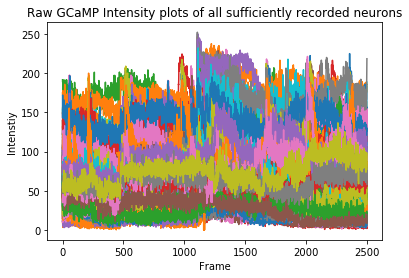

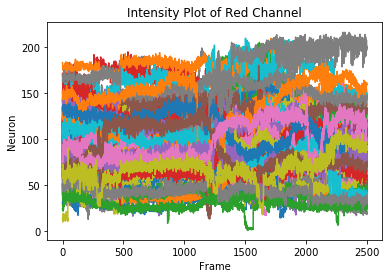

In [15]:
#plot raw neuronal intensities & display number of fully tracked neurons
number_of_neurons = len(intensities)
print('number of neurons = ', number_of_neurons)

for track in range(len(intensities)):
    plt.plot(intensities[track])
    plt.title('Raw GCaMP Intensity plots of all sufficiently recorded neurons')
    plt.xlabel('Frame')
    plt.ylabel('Intenstiy')
plt.show()

#Plot intensities of red channels - used to identify motion artefacts and leaking between channels
for track in range(len(intensities)):
    plt.plot(intensities_red[track])
    plt.title('Intensity Plot of Red Channel')
    plt.xlabel('Frame')
    plt.ylabel('Neuron')

C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number o

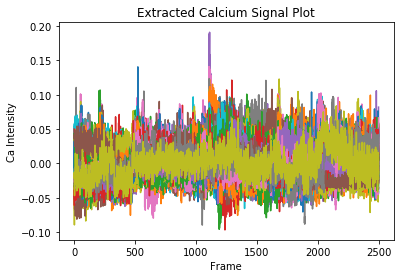

In [16]:
#DeltaR/R or ICA used to correct for motion artefacts and cross channel leaking
#Obtain Artefact Free Ca Signal
CaSignal = ICAdecorr(intensities, intensities_red, 0.5, 10)

#Plot Signal
for i in range(len(CaSignal)):
    plt.plot(CaSignal[i])
plt.title('Extracted Calcium Signal Plot')
plt.xlabel('Frame')
plt.ylabel('Ca Intensity')
plt.show()

In [ ]:
#Plot Heatmap of Calcium Signal
#can normalise here for better signal...
plot_heatmap(CaSignal, 'Heatmap of Extracted Calcium Signal', 'Ca Signal Intensity')

Calcium Signal Extraction - Optional Cells
--------------------------
**These Cells Dont Need to be Run**          
Cells for evaluating performance or saving preliminary results        
Only Run the Cells you want to

**Optional Cells to Evaluate ROI Tracking**      
Input frame number to view all of the ROIs tracked in that frame      

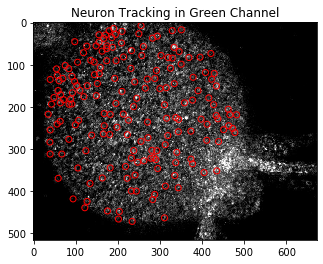

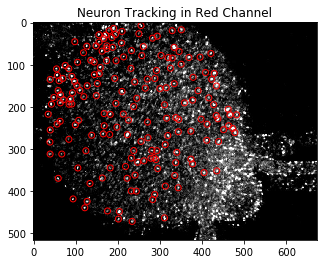

In [17]:
#superimpose ROIs on video frame in both channels

#select frame to view
frame_to_view = 1606

Super_impose(vid, frame_to_view, 'Neuron Tracking in Green Channel')
Super_impose(red_vid, frame_to_view, 'Neuron Tracking in Red Channel')

**Optional Cells to Evaluate Effect and Correction of Motion Artifacts and Red Leakage**

In [ ]:
#Plot Raw Transients in Green
plot_all(intensities)

In [ ]:
#Plot Red Transient to check for motion artefacts and leaking
Neuron_with_possible_artefact = 11

plt.figure(1)
plt.title('Raw Red Channel Plot')
plt.plot(intensities_red[Neuron_with_possible_artefact])
plt.show()

#After Correction:
plt.figure(2)
plt.plot(CaSignal[Neuron_with_possible_artefact])
plt.title('Calcium Signal Plot')
plt.show()

**Optional Cell to Evaluate Activity and Tracking of Individual Neurons**     
Allows comparison between intensity trace of a neuron and that neuron's ROI at a particular frame    
Input Neuron Number and Frame Number

In [ ]:
#input neuron to check
neuron = 12

#input frame form video to view the ROI
eval_frame = 509

full_eval(neuron, CaSignal, eval_frame, dim, posit_corrected)

FILTERING & SMOOTHING
-----------------------

The following cells will filter the intensity traces of the neurons to remove signal that are likely from nematocytes, smooth the results to reduce the appearance of noise, and detrend the resulting data

In [18]:
#Detrending data - use on filtered or smoothed data

#Set Polynomial Degree
poly_deg = 17

detrended = detrend_all(CaSignal, poly_deg)

C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anacond

C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anacond

C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anacond

C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anaconda3\envs\Caiman_NOAH3\lib\site-packages\ipykernel_launcher.py:370: RankWarning: Polyfit may be poorly conditioned
C:\Users\rylab\AppData\Local\Continuum\anacond

In [19]:
temp1 = posit_corrected
temp2 = detrended

#posit_corrected = temp1
#detrended = temp2

In [ ]:
#Filter Nematocytes

#set the threshold to remove below
#standard option is to set to 20 (i.e. filter will remove signals with below the 20th percentile of standard deviations)
#percentile_threshold = 10 #zero = no filtering
#filt, posit_corrected = filt_nematocytes(CaSignal,percentile_threshold,posit_corrected)
alpha = 1e-6 #Tune threshold for coherence to gaussian distribution - need to use detrended data with this function
detrended, posit_corrected, removed = Gaussian_noise_filter(detrended, alpha, posit_corrected)
#evaluate filtering of neurons

plot_all(removed)

In [ ]:
#Smooth Signals

# #Set Smoothing window Size
#window = 2

#smooth_intensities = smoother(filt, window)
#detrended = smooth_intensities

In [ ]:
#Display Filtering and Smoothing Results

#Display Total Number of Neurons After Filtering
print('no of neurons: ', len(detrended))

# plt.figure(1)
# for i in range(len(filt)):
#     plt.plot(filt[i])
# plt.title('Calcium Signal with Nematocytes Filtered')
# plt.xlabel('Frame')
# plt.ylabel('Calcium Signal')
# plt.show()

# plt.figure(2)
# for i in range(len(smooth_intensities)):
#     plt.plot(smooth_intensities[i])
# plt.title('Smoothed Filtered Fluorescence with Single Neuron Resolution')
# plt.xlabel('Frame')
# plt.ylabel('Calcium Signal')
# plt.show()

plt.figure(3)
for i in range(len(detrended)):
    plt.plot(detrended[i])
plt.title('Detrended Calcium Signal Data')
plt.xlabel('Frame')
plt.ylabel('Calcium Signal Detrended')
plt.show()

plot_heatmap(norm_all_data(detrended), 'Heatmap of Filtered Detrended Data', 'Calcium Signal Intensity')

In [ ]:
#Plot all remaining neurons after filtering and processing
plot_all(detrended)

CALCIUM SIGNAL ANALYSIS
-------------------------------------

The following cells analyse the results to show extract spikes from the Calcium intensity data

**Tune Threshold used to Indentify Spikes to Fit Data Using Evaluation Cell for FOOPSI at End of Script**

In [20]:
#Create Raster Plot using CAIMAN's FOOPSI function - Denoising and Deconvolution

#foopsi
Foopsi_ca, spikes_signal_dR = FOOPSI_all(detrended)

In [ ]:
#Plot all denoised calcium traces
plot_all(spikes_signal_dR)

In [21]:
#Extract Raster Plot Data

#Threshold (could use a theoretical value for threshold! - See CAIMAN Docs - but trial & error is also fine)
#USE FOOPSI EVALUATION CELL TO TUNE THIS PARAMETER (0.04 works well)
spike_thresh_dR = 0.1

raster_array_dR = Find_Raster_adaptive(spikes_signal_dR, spike_thresh_dR)

100%|██████████| 179/179 [02:02<00:00,  1.46it/s]


In [ ]:
plot_heatmap(norm_all_data(Foopsi_ca), 'Denoised heatmap', 'Intensity')

In [ ]:
#Display Results

#plot raster
#zero values from way array was made array give large syncronous train at start of the signal - should fix (.append method?)
plt.figure(2)
plt.eventplot(raster_array_dR,linelengths = 0.6)
plt.ylabel('Neuron')
plt.xlabel('Frame')
plt.title('Raster Plot of Neural Activity of Hydra')
plt.xlim((1,len(raster_array_dR[0])))
plt.show()

In [ ]:
#plot rasterplot for all neurons
for i in range(len(raster_array_dR)):
    plt.eventplot(raster_array_dR[i],linelengths = 0.1)
    plt.xlim((1,len(raster_array_dR[0])))
    plt.title(i)
    plt.show()

BEHAVIOUR ANALYSIS WITH NEURAL ACTIVITY
---------------------------------------------
These cells plot neural activity and behaviour together to allow comparision between neural activity and behaviour     
Most of this step still needs to be done by hand unfortunately...

In [22]:
#Input Behaviour Arrays

#behaviour array: [frame behaviour turns on,frame off,on,off,on,... etc]
behaviour_frames = []

#fill with numbered behaviourws in order they occur
behaviours = []

#fill with colours corresponding to numbered behaviours
colours=['blue','green']

In [ ]:
#Display Neural Activity with Behaviour

plt.figure(1)
fig, ax = plt.subplots()
ax.margins(0.02)
for behav in range(len(behaviour_frames)-1):
    colour_face = colours[behaviours[behav]]
    ax.axvspan(behaviour_frames[behav],behaviour_frames[behav+1], facecolor = colour_face, alpha = 0.2)
for i in range(len(intensities)):
    plt.plot(intensities[i])
plt.title('Raw Intensities plotted with CB and RP behaviour (CB=green)')
plt.xlabel('Frame')
plt.ylabel('Intensity')
plt.show()

plt.figure(2)
fig, ax = plt.subplots()
ax.margins(0.02)
for behav in range(len(behaviour_frames)-1):
    colour_face = colours[behaviours[behav]]
    ax.axvspan(behaviour_frames[behav],behaviour_frames[behav+1], facecolor = colour_face, alpha = 0.2)
for i in range(len(detrended)):
    plt.plot(detrended[i])
plt.title('Processed Intensities plotted with CB and RP behaviour (CB=green)')
plt.xlabel('Frame')
plt.ylabel('Calcium Signal Intensities Detrended')
plt.show()

plt.figure(3)
fig, ax = plt.subplots()
ax.margins(0.02)
for behav in range(len(behaviour_frames)-1):
    colour_face = colours[behaviours[behav]]
    ax.axvspan(behaviour_frames[behav],behaviour_frames[behav+1], facecolor = colour_face,alpha = 0.2)
plt.eventplot(raster_array_dR,linelengths = 0.6)
plt.xlim((1,len(raster_array_dR[0])))
plt.ylabel('Neuron')
plt.xlabel('Frame')
plt.title('Raster Plot of Neural Activity of Hydra Plotted with Behaviour')
plt.show()

CORRELATION AND INTERPRETATION OF DATA
-----------------------------------
The following cells work to group neurons together into ensembles, display various froms of correlation data presentation, and correlate each neuron to different types of behaviour

**Input Correlation Threshold to be Used to Group Neurons**

In [ ]:
#Create Dendrogram (can change method between ward, average, etc)
CaSignal_norm = spikes_signal_dR
plt.figure(figsize=(20, 20))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(CaSignal_norm, method='ward'),leaf_font_size=10,color_threshold = 0.1)

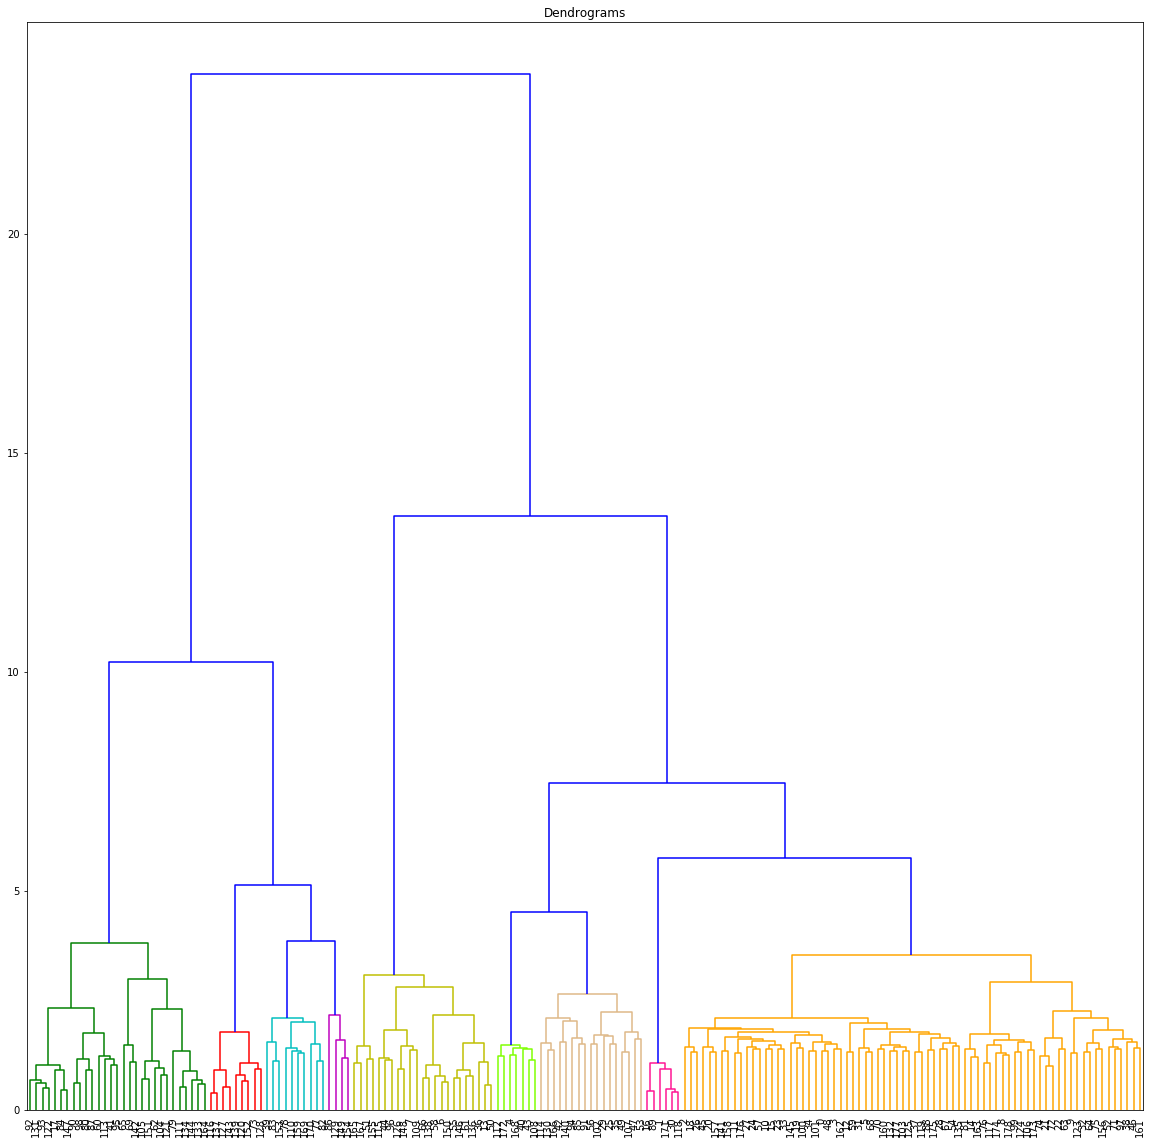

In [25]:
CaSignal_norm = spikes_signal_dR
df = pd.DataFrame(np.transpose(CaSignal_norm))
plt.figure(figsize=(20, 20))  
plt.title("Dendrograms")
palette = ['g','r','c','m','y','chartreuse','burlywood','DeepPink','orange']
shc.set_link_color_palette(palette)
dend = shc.dendrogram(shc.linkage(df.corr(), method='ward'),leaf_font_size=10,color_threshold = 3.8)

In [26]:
cluster_info = get_cluster_classes(dend)
get_cluster_classes(dend)

g,"{'121', '41', '104', '98', '60', '142', '69', '65', '122', '84', '147', '113', '133', '17', '80', '87', '79', '90', '92', '144', '134', '62', '93', '111', '105', '131', '164', '151', '95'}"
r,"{'128', '152', '139', '143', '127', '116', '120', '137', '73'}"
c,"{'110', '78', '169', '82', '39', '83', '153', '170', '159', '77'}"
m,"{'149', '154', '86', '129'}"
y,"{'51', '44', '136', '165', '109', '58', '6', '61', '150', '148', '55', '146', '138', '155', '167', '13', '126', '7', '50', '66', '96', '36', '115'}"
chartreuse,"{'108', '112', '172', '43', '40', '4', '168'}"
burlywood,"{'107', '49', '47', '42', '56', '91', '53', '102', '85', '114', '29', '140', '130', '94', '166', '35', '25'}"
DeepPink,"{'16', '89', '171', '1', '118', '30'}"
orange,"{'54', '3', '158', '2', '119', '28', '48', '81', '57', '0', '9', '97', '68', '145', '31', '103', '125', '161', '176', '11', '100', '12', '71', '33', '52', '76', '99', '157', '15', '117', '74', '21', '37', '5', '72', '32', '175', '70', '59', '106', '20', '174', '75', '178', '63', '67', '34', '124', '24', '163', '38', '177', '88', '135', '132', '14', '101', '10', '141', '46', '27', '156', '26', '45', '19', '8', '123', '160', '173', '64', '22', '18', '23', '162'}"


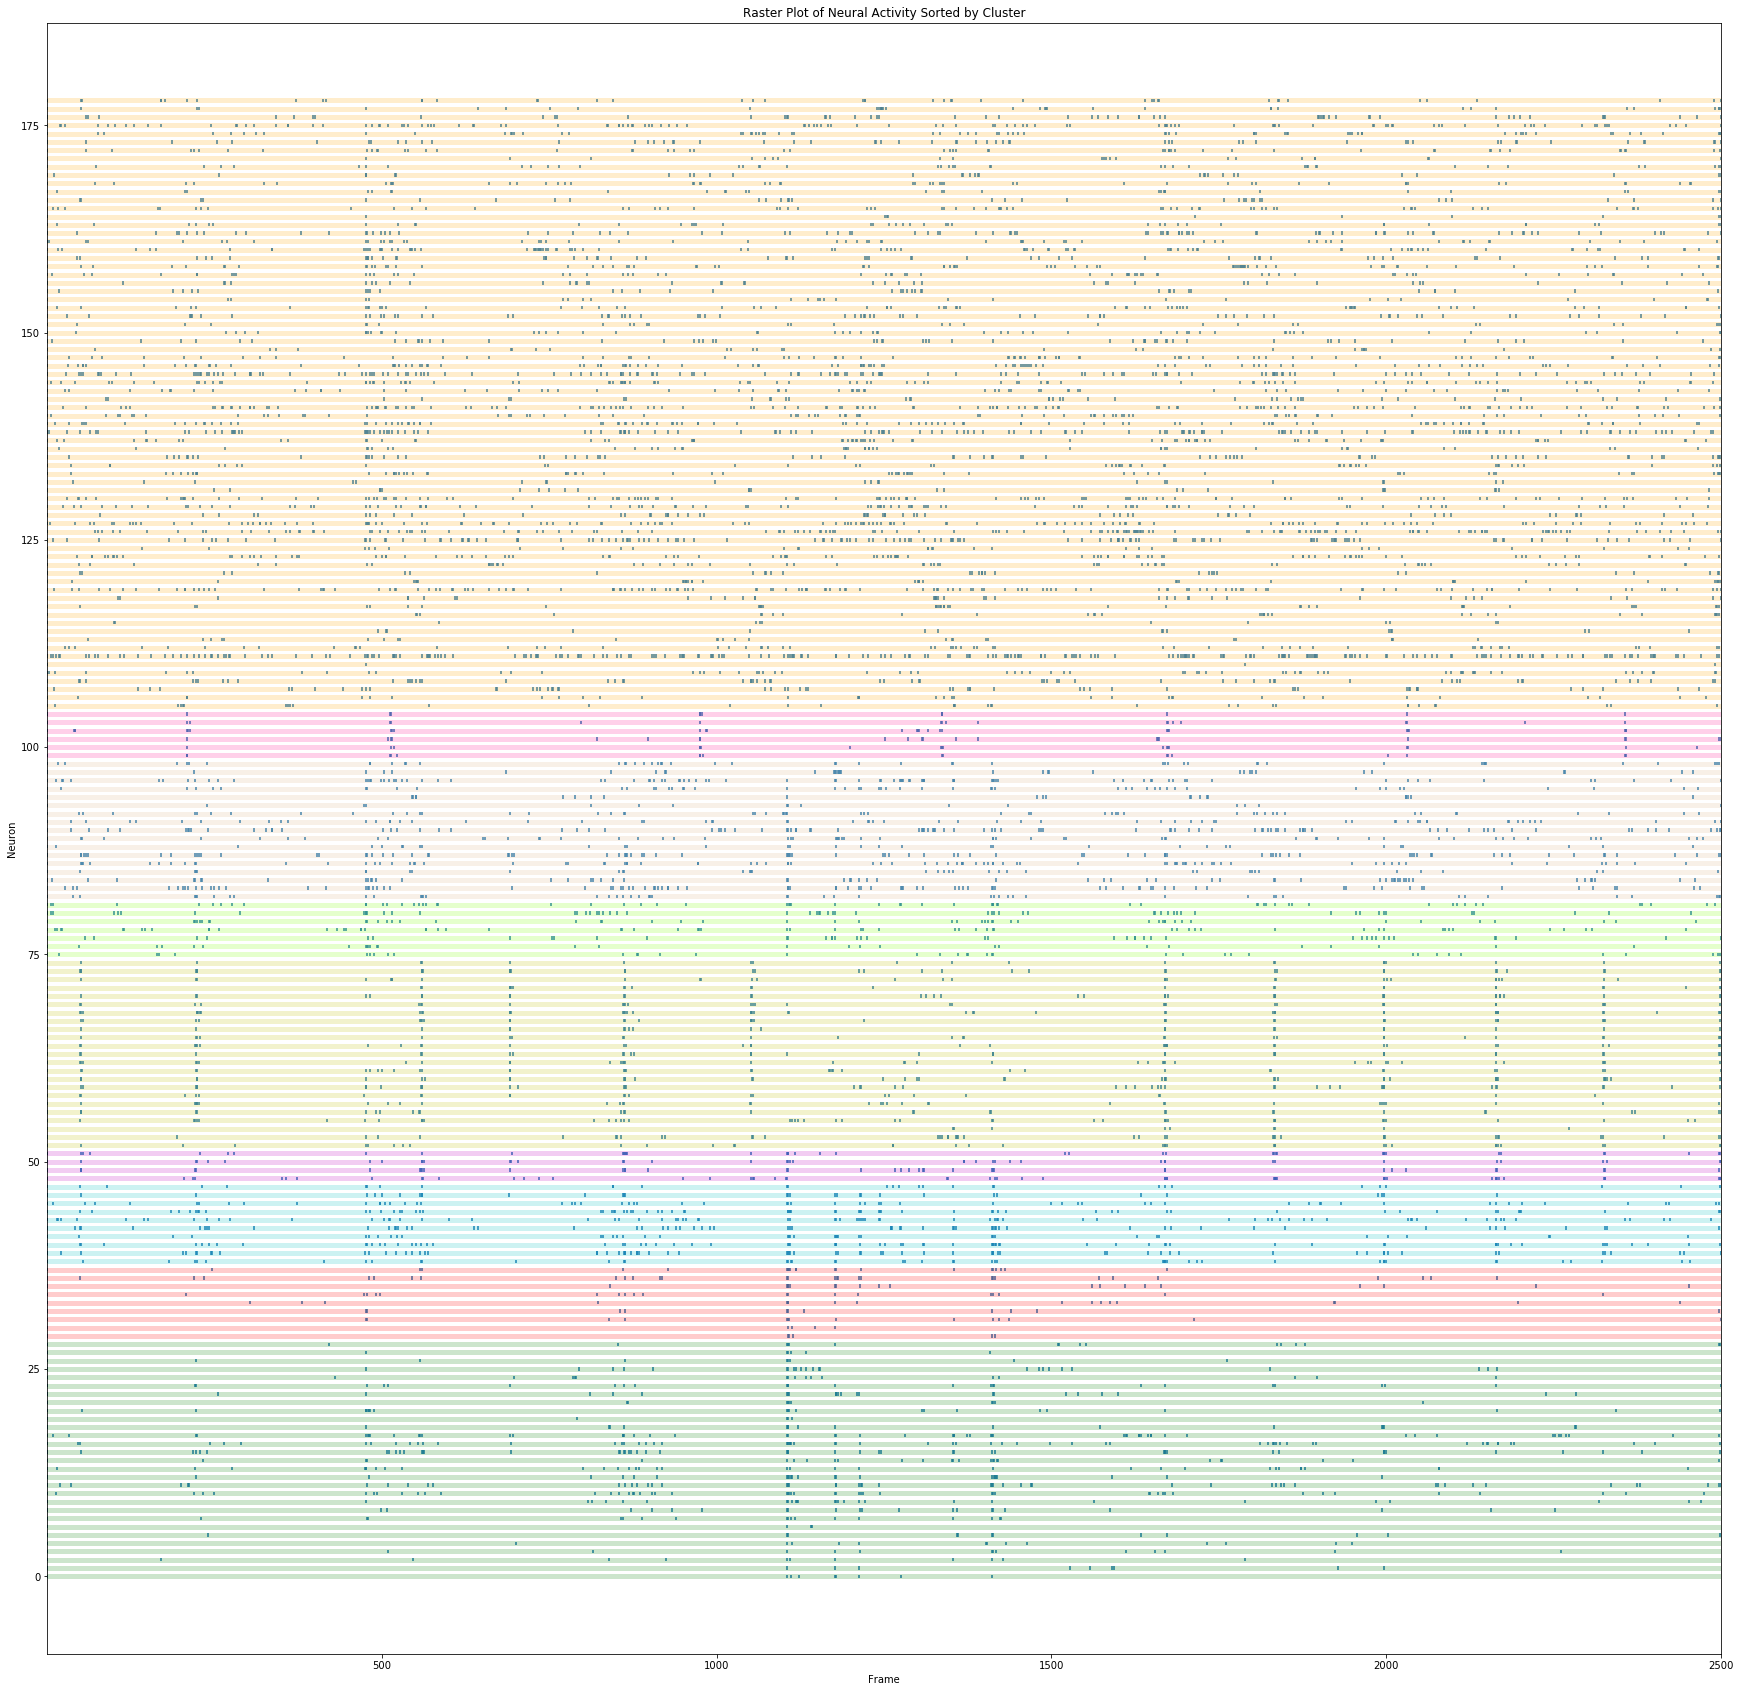

In [27]:
mylist = raster_array_dR
myorder = dend['leaves']
mylist = [mylist[i] for i in myorder]
cluster_info = get_cluster_classes(dend)
plt.figure(figsize=(30, 30))
for col in set(dend['color_list']):
    if col != 'b':
        for row in cluster_info[col]:
            plt.axhline(y=dend['leaves'].index(int(row)), color = col, alpha = 0.2, linewidth=5)

for behav in range(len(behaviour_frames)-1):
    colour_face = colours[behaviours[behav]]
    plt.axvspan(behaviour_frames[behav],behaviour_frames[behav+1], facecolor = colour_face,alpha = 0.2)
    
plt.eventplot(mylist,linelengths = 0.4)
plt.xlim((1,len(raster_array_dR[0])))
plt.ylabel('Neuron')
plt.xlabel('Frame')
plt.title('Raster Plot of Neural Activity Sorted by Cluster')
plt.show()

###### **Input Number of Clusters Based on Results from Dendogram**

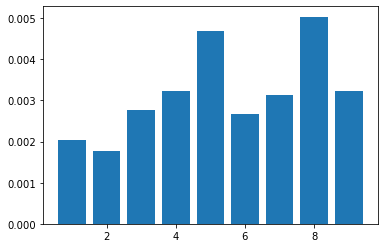

In [28]:
#extract and view neurons from each cluster 

#number of clusters chosen from examination of dendogram
#number_of_clusters = 7

# use this function for Eucledian dendrograms
#clusters = give_cluster_assigns(pd.DataFrame(np.transpose(CaSignal_norm)), number_of_clusters, transpose=True)
#clusters = clusters.values


# Use this instead for Correlation dendrograms

# manually set the colors from the dendrogram
cluster_colors = palette

clusters = np.zeros((len(raster_array_dR),), dtype=int)
number_of_clusters = 0
for col in set(dend['color_list']):
    if col != 'b':
        number_of_clusters += 1
        for row in cluster_info[col]:
            clusters[int(row)] = cluster_colors.index(col)+1
   
                     
#plot specific cluster's neurons traces

cluster_to_view = 0
average_intensities = np.zeros(number_of_clusters)
cluster_sizes = np.zeros(number_of_clusters)

for i in range(len(clusters)):
    average_intensities[clusters[i]-1] += np.sum(Foopsi_ca[i])/len(vid)
    cluster_sizes[clusters[i]-1] += 1
    if clusters[i] == cluster_to_view:
        plt.figure(i-1)
        plt.title(i)
        plt.eventplot(raster_array_dR[i])
        plt.show()


average_intensities = average_intensities/cluster_sizes
plt.bar(range(1,number_of_clusters+1),average_intensities)
plt.show()

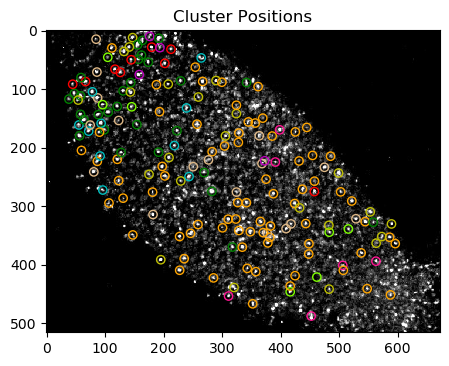

In [30]:
#Super impose locations of neurons in specified Cluster onto video frame

os.chdir('C:\\Users\\rylab\\Desktop\\AliA\\Best 10X\\')
cwd = os.getcwd()
#os.mkdir('test')
os.chdir('test')

color_codes = ['']*len(raster_array_dR)
for i in range(len(color_codes)):
    for color,track in cluster_info.items():
        temp = str(i)
        if temp in track:
            color_codes[i] = str(color)
                
cluster_to_view = [1,2,3,4,5,6,7,8,9]
frame_for_cluster = 0
number_of_frames = len(vid)
video_for_cluster = red_vid
title_for_cluster = 'Cluster Positions'

Super_impose_cluster(video = video_for_cluster, frame_to_view = frame_for_cluster, \
                     posit_corrected = posit_corrected, clusters = clusters, cluster_to_view = cluster_to_view, \
                     Title = title_for_cluster, sequence = number_of_frames, color_codes = color_codes)

os.chdir(cwd)

In [ ]:
df = pd.DataFrame(np.transpose(CaSignal_norm))
plt.matshow(df.corr())
plt.show()
corr = df.corr()
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, ax=ax)

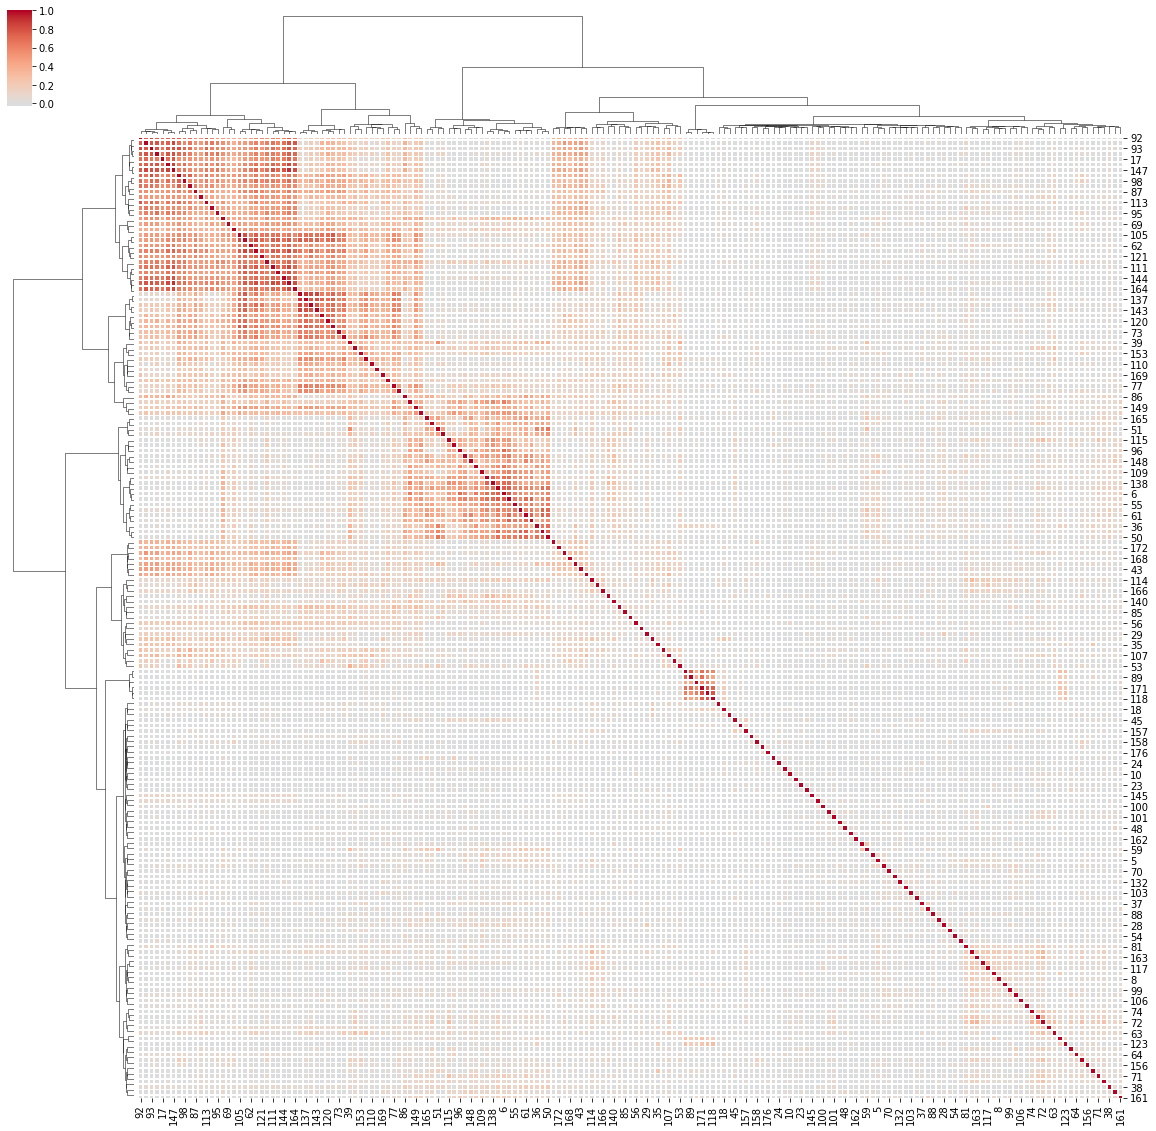

In [29]:
#ClusterMap
#change figure size to see all labels if necessary

df = pd.DataFrame(np.transpose(CaSignal_norm))

# Draw the full plot
sns.clustermap(df.corr(), center=0, cmap="coolwarm",linewidths=.75, figsize=(20,20), method = 'ward')

In [ ]:
binarized = (raster_array_dR > 0).astype(int)
with open('test.txt', 'w') as f:
    for j in range(binarized.shape[1]):
        f.write("> Frame #" + str(j) + "\n")
        temp = ''
        for i in range(binarized.shape[0]):
            if binarized[i][j] == 1:
                temp += 'A'
            else:
                temp += 'M'
        #print(temp)
        f.write(temp)
        f.write("\n\n")
        
with open('hydra_raster.txt', 'w') as f:
    for j in range(binarized.shape[1]):
        temp = ''
        for i in range(binarized.shape[0]):
            if binarized[i][j] == 1:
                temp += '1'
            else:
                temp += '0'
        f.write(temp)
        f.write("\n")

In [ ]:
#Investigate Correlations from ClusterMap

#input neurons to view
neuron_1 = 71
neuron_2 = 36

plt.figure(1)
fig, ax = plt.subplots()
ax.margins(0.02)
for behav in range(len(behaviour_frames)-1):
    colour_face = colours[behaviours[behav]]
    ax.axvspan(behaviour_frames[behav],behaviour_frames[behav+1], facecolor = colour_face,alpha = 0.2)
plt.plot(detrended[neuron_1])
plt.plot(detrended[neuron_2])
plt.show()

plt.figure(2)
plt.title(neuron_1)
plt.eventplot(raster_array_dR[neuron_1],linelengths = 0.6)
plt.xlim((1,len(raster_array_dR[0])))
plt.show()

plt.figure(3)
plt.title(neuron_2)
plt.eventplot(raster_array_dR[neuron_2],linelengths = 0.6)
plt.xlim((1,len(raster_array_dR[0])))
plt.show()

In [ ]:
#Single neuron investigation

neuron_to_investigate = 50
frame_to_investigate = 1606

single_neuron_investigation(neuron_to_investigate, CaSignal, vid, frame_to_investigate, dim, posit_corrected)

**Save Data**
===============
**Optional Cells to Save Results**        
Run these cells to save the data as a .csv         
Input file name and path where file should be saved           
**On Windows: Paths still need to start with 'r'**              
e.g. r'C:\Users\rylab\Documents\path to your folder\title.csv'

**Save Raw GCamp Intensity Data**

In [ ]:
#Save Raw GCamp Intensity data as a .csv 

# Save_Path = r'C:\Users\rylab\Documents\Noah2019_desktop\Columbia_Project\hydra_Vids\2-colour\single_cell_intensity_behaviour_longclip.csv'

# intensity_dataframe = pd.DataFrame(intensities)
# intensity_dataframe.to_csv(Save_Path)

**Save CaSignal Intensity Data**

In [ ]:
#save CaSignal data to .csv

# Ca_save_path = r'C:\Users\rylab\Documents\Noah2019_desktop\Columbia_Project\hydra_Vids\2-colour\single_cell_CaSig.csv'

# intensity_dataframe = pd.DataFrame(CaSignal)
# intensity_dataframe.to_csv(Ca_save_path)

**Sava Detrended Intensity Data**

In [ ]:
#save detrended data to .csv

# dR_detrend_save_path = r'C:\Users\rylab\Documents\Noah2019_desktop\Columbia_Project\hydra_Vids\2-colour\single_cell_detrend.csv'

# dfintensity_dataframe = pd.DataFrame(detrended)
# dfintensity_dataframe.to_csv(dR_detrend_save_path)

**Save Foopsi De-noised Data**

In [ ]:
# #save Foopsi de-noised data to .csv

# Ca_denoised_path = r'C:\Users\rylab\Documents\Noah2019_desktop\Columbia_Project\Project_Behaviour_and_Neural_Activity\Single_Cell_Analysis_Neural\Single_Cell_Data\VID1_oct_4_3hz\Results\denoised_neuraldata.csv'

# ca_dataframe = pd.DataFrame(Foopsi_ca)
# ca_dataframe.to_csv(Ca_denoised_path)

**Save Raster Plot Data**

In [ ]:
#save raster data to .csv (needs to be reformatted from event plot form first)

# raster_save_path = r'C:\Users\rylab\Documents\Noah2019_desktop\Columbia_Project\hydra_Vids\2-colour\single_cell_rasterb1.csv'

# raster_array_pred = np.zeros((len(raster_array_dR),len(raster_array_dR[1])))
# for i in range(len(spikes_signal_dR)):
#     for j in range(len(spikes_signal_dR[i])):
#         if max(spikes_signal_dR[i]) > 0:
#             if spikes_signal_dR[i][j] >= spike_thresh_dR: #*np.mean(spikes_signal_dR[i]):
#                 raster_array_pred[i][j] = 1

# raster_dataframe = pd.DataFrame(raster_array_pred)
# raster_dataframe.to_csv(raster_save_path)

**Save Behaviour Data**

In [ ]:
#Save Behaviour Array tp .csv
# behaviour_Save_Path = r"C:\Users\rylab\Downloads\behav_array.csv"

# behav_array = np.zeros(len(vid))
# for i in range(len(behaviours)):
#     behav_array[behaviour_frames[i]:behaviour_frames[i+1]] = behaviours[i]
    
# behaviour_dataframe = pd.DataFrame(behav_array)
# behaviour_dataframe.to_csv(behaviour_Save_Path)

**Evaluation Cells**
====================
These cells allow for the evaluation of the tuning of various functions

**Evaluate Polynomial Detrending Parameters** 

In [ ]:
#evaluate ploynomail detrending
neuron_test_detrend = 10
#polynomial degree of 15-17 gives good results - but tune for new data!
polynomial_test_degree  = 12
detrend_one = detrend(smooth_intensities[neuron_test_detrend],polynomial_test_degree)
plt.figure(1)
plt.plot(detrend_one, c='b')
plt.plot(smooth_intensities[neuron_test_detrend], c = 'r')
plt.show()

**Evaluste ICA vs Ratiometric Artefact Removal**

In [ ]:
# New ICA vs Ratiometric

a, b = np.asanyarray(norm_Data(intensities[12])), np.asanyarray(norm_Data(intensities_red[12]))
plt.plot(a, c = 'g')
plt.title('Raw Intensities of GCaMP7 (Green) Channel')
plt.xlabel('Frames')
plt.ylabel('Normalised Intensity')
plt.show()
plt.plot(b, c = 'r')
plt.title('Raw Intensities of tdTomato (Red) Channel')
plt.xlabel('Frames')
plt.ylabel('Normalised Intensity')
plt.show()

c = (a+1)/(b+1)
plt.plot(c)
plt.title('Ratiometric Correction of Motion Artefacts')
plt.xlabel('Frames')
plt.ylabel('Intensity Ratio')
plt.show()

print(min(a))
print(min(b))

ica_g = ICAdecorr([a],[b],0.05, 10)
plt.plot(ica_g[0])
plt.title('ICA Correction of Motion Artefacts')
plt.xlabel('Frames')
plt.ylabel('Normalised Intensity')
# plt.show()
# plot_all(p)
# print(c)

**Evaluate FOOPSI Parameters**

In [ ]:
#Tuning for FOOPSI 

tuning_thresh_foopsi = 0.001

evaluation_neuron_foopsi = 10
spikes_signal_tuning = FOOPSI_all(normalize(detrended))

plt.figure(1)
plt.plot(detrended[evaluation_neuron_foopsi])
plt.title('detrended signal for Specified Neuron')
plt.ylabel('Calcium Signal Detrended Intensity')
plt.xlabel('Frame Number')
plt.show()

plt.figure(2)
plt.plot(spikes_signal_dR[evaluation_neuron_foopsi])
plt.title('FOOPSI Results for Specified Neuron')
plt.ylabel('Estimated Neural Activity')
plt.xlabel('Frame Number')
plt.show()

**Evaluate use of ICA or DeltaR/R to separate signal from noise**

In [ ]:
#ICA artifact removal comparison cell
ICA_test_neuron = 9
R = intensities_red
G = intensities

a = decorrelateNeuronsICA(R, G, 0.2)

plt.plot(G[ICA_test_neuron], c = 'g')
plt.plot(R[ICA_test_neuron], c = 'r')
plt.show()

plt.plot(a[ICA_test_neuron], c = 'g')
plt.title('ICA')
plt.show()

plt.plot(deltaR[ICA_test_neuron], c = 'r')
plt.title('DR/R')
plt.show()

**Find Raster Plot from Non-DR/R data**    
Recalculates the spikes from the raw data and plots the results      
Evaluates best input to use with FOOPSI Algorithm

In [ ]:
#raster with non-dR/R - Compare Rasters from different input data

Raw_filt, _ = np.asanyarray(filt_nematocytes(intensities, 5, positions))

raw_smooth = smoother(Raw_filt, 5)

df_f_signal = np.asanyarray(df_f(raw_smooth))


plt.figure(1)
for i in range(len(raw_smooth)):
    plt.plot(raw_smooth[i])
plt.title('Intensity Plot Raw smooth')
plt.xlabel('Frame')
plt.ylabel('Intensity')
plt.show()

#Create Raster Plot using CAIMAN's FOOPSI function
#foopsi (used on non-df/f data)
spikes_signal = np.zeros((len(Raw_filt),len(Raw_filt[1])))
for i in range(len(Raw_filt)):
    ca_foopsi,cb,b1,g,c1,spikes_foopsi,lam = deconv.constrained_foopsi(Raw_filt[i],p=2)
    spikes_signal[i] = spikes_foopsi
    
#foopsi (used on df/f data)
spikes_signal_df = np.zeros((len(df_f_signal),len(df_f_signal[1])))
for i in range(len(df_f_signal)):
    ca_foopsi,cb,b1,g,c1,spikes_foopsi,lam = deconv.constrained_foopsi(df_f_signal[i],p=2)
    spikes_signal_df[i] = spikes_foopsi

#threshold to find spikes
spike_thresh = 0.3

raster_array = np.zeros((len(Raw_filt),len(Raw_filt[1])))
for i in range(len(spikes_signal)):
    for j in range(len(spikes_signal[i])):
        if spikes_signal[i][j] >= spike_thresh*max(spikes_signal[i]):
            raster_array[i][j] = j

raster_array_df = np.zeros((len(df_f_signal),len(df_f_signal[1])))
for i in range(len(spikes_signal_df)):
    for j in range(len(spikes_signal_df[i])):
        if spikes_signal_df[i][j] >= spike_thresh*max(spikes_signal_df[i]):
            raster_array_df[i][j] = j

#Plot raster for base data
#zero values from way array was made array give large syncronous train at start of the signal - should fix (.append method?)
plt.figure(3)
plt.eventplot(raster_array,linelengths = 0.5)
plt.title('Raster Plot of All Neurons (raw intensities)')
plt.xlabel('Frame Number')
plt.ylabel('Neuron')
plt.show()

plt.figure(4)
plt.eventplot(raster_array_df,linelengths = 0.5)
plt.title('Raster Plot of All Neurons (df/f intensities)')
plt.xlabel('Frame Number')
plt.ylabel('Neuron')
plt.show()

**Alternative Clustering Visualisation**

In [ ]:
#Clustering Data - evaluate clustering with a cluster map (provides some extra visualisation if you want it but I prefer other methods)
#Input Number of Clusters Based on Results from Dendogram

eucdist = cdist(CaSignal_norm,CaSignal_norm)
cluster = AgglomerativeClustering(n_clusters=number_of_clusters, affinity='euclidean')
cluster.fit_predict(CaSignal_norm)
plt.figure(figsize=(10, 7))  
plt.scatter(eucdist[:,1], eucdist[:,0],c=cluster.labels_) 

**Evaluate Raster Reshaping**

In [ ]:
# #Evaluate Raster Reshaping step for saving as csv

# raster_reshape_test_neuron = 5

# plt.plot(raster_array_pred[raster_reshape_test_neuron], color = 'r')
# plt.eventplot(raster_array_dR[raster_reshape_test_neuron])

**Evaluate Neuron Tracking**

In [ ]:
n = 57
_,_,_,display = SingleCellIntensity(neuron = n, video = vid, positions = posit_corrected, dimentionROI = dim, Circle_radius = 4, distance_threshold = 4, display_on = True)

**Save Tracked Neurons**

In [ ]:
# for i in range(len(display)):
#     plt.imshow(display[i])
#     title = 'neuron_' + str(i) + '.tif'
#     plt.savefig(str(title), format = 'tif')

Experimental Cells
===============

In [ ]:
#raster using peak detection function - needs tuning...

neuron_for_peaks = 50
distance_between_peaks = 10
prominance_of_peaks = 0.05

a,b = sp.signal.find_peaks(detrended[neuron_for_peaks], distance = distance_between_peaks, prominence = prominance_of_peaks)
plt.figure(1)
plt.plot(detrended[neuron_for_peaks])
plt.plot(a, detrended[neuron_for_peaks][a], 'x')
plt.show()

raster2 = np.zeros((len(detrended), len(detrended[1])))
for i in range(len(detrended)):
    peaks,_ = sp.signal.find_peaks(detrended[i], distance = distance_between_peaks, prominence = prominance_of_peaks)
    for j in range(len(detrended[i])):
        for k in range(len(peaks)):
            raster2[i][peaks[k]] = 1

plt.figure(2)
plt.plot(raster2[neuron_for_peaks])
plt.show()

In [ ]:
#frequency filtering
#sampling rate = 3Hz
#hmm doesnt seem to work well at all

neurons = 10

frqs = np.fft.fft(detrended[neuron])
xax = np.arange(0,6000, 6000/(len(detrended[0])))
plt.figure(1)
plt.title('Fourier Spectrum')
plt.plot(abs(frqs.real))


#freqs adjusted
filter_block = np.ones(len(detrended[0]))
low_pass_cut = 30
filter_block[low_pass_cut:len(filter_block)-low_pass_cut] = 0
#filter_block[len(filter_block) - 80: len(filter_block) - 55] = 1
plt.plot(filter_block)
plt.show()
new_freqs = np.fft.ifft(frqs*filter_block)

plt.figure(2)
plt.plot(new_freqs)
plt.show()

In [ ]:
# #independant component analysis to separate noise - single neuron

# ica_test_neuron = 9
# window = 5

# data_green = [intensities[ica_test_neuron]]
# filtered_data_g = smoother(data_green,window)
# filtered_data_g = np.transpose(detrend(np.transpose(filtered_data_g), 17))
# plt.figure(1)
# plt.plot(filtered_data_g[0],c='g')
# # plt.plot(data_green[0],'r')

# data_red = [intensities_red[ica_test_neuron]]
# filtered_data_r = smoother(data_red,window)
# filtered_data_r = np.transpose(detrend(np.transpose(filtered_data_r), 17))
# plt.figure(2)
# plt.plot(filtered_data_r[0],c='r')
# # plt.plot(data_red[0],'r')
# plt.show()

# X = np.c_[filtered_data_g[0],filtered_data_r[0]]
# print(X.shape)
# X = X.reshape(len(filtered_data_g[0]),2)
# print(X.shape)
# # scaler= StandardScaler(copy=True, with_mean=True, with_std=True)
# # X = scaler.fit_transform(X)
# ica = FastICA(n_components = 2, random_state = None)
# A = ica.fit_transform(X)

# plt.figure(3)
# plt.plot(X[:,0], c='g')
# plt.plot(X[:,1], c='r')
# plt.plot(data_green, c='b')
# plt.plot(data_red, c='y')
# plt.figure(4)
# plt.plot(A[:,0])
# plt.plot(A[:,1])
# plt.show()

In [ ]:
# #Correlation Between Neural Activity and Behaviour
# #Method finds change in neural activity between CB and RP

# #select neuron to observe
# neuron = 44

# #select lenght of sub sequences (will depend on number of frames behaviour takes up)
# seqlen = 100

# df_on = smooth_intensities[neuron][301:565] + smooth_intensities[neuron][991:1076]
# df_ons = []
# for i in range(int(len(df_on)/seqlen)):
#     df_ons.append(df_on[i*seqlen:(i*seqlen)+seqlen])

# df_off = smooth_intensities[neuron][0:301] + smooth_intensities[neuron][565:991] + smooth_intensities[neuron][1076: len(smooth_intensities[0])]
# df_offs = []
# for i in range(int(len(df_off)/seqlen)):
#     df_offs.append(df_off[i*seqlen:(i*seqlen)+seqlen])
    
# #find average of on signal
# avg_on = []
# for i in range(len(df_ons[0])):
#     values = []
#     for j in range(len(df_ons)):
#         values.append(df_ons[j][i]) 
#     avg_on.append(np.mean(values))

# #find average of off signal
# avg_off = []
# for i in range(len(df_offs[0])):
#     values = []
#     for j in range(len(df_offs)):
#         values.append(df_offs[j][i]) 
#     avg_off.append(np.mean(values))

# #correlation
# corr_on_off = np.corrcoef(avg_off,avg_on)[0,1]
# print('Pearson Correlation Coeff: ', corr_on_off)

# #if correlation is very low, neurons change activity patterns during behaviour!!
# if abs(corr_on_off) < 0.5:
#     print('Neuron Changes Activity During Behaviour')
# else:
#     print('Neuron Does Not Change Activity During Behaviour')
    
# plt.plot(avg_on)
# plt.plot(avg_off)
# plt.show()